**Proximal Policy Optimization (PPO) for CartPole-v1**

Implementing a clipped actor-critic PPO agent to solve the CartPole balancing task using PyTorch and Gymnasium.

**Implementing the PPO  for the cartpole environment  require**:
> Environment Interaction
> Actor-Critic Networks
> Generalized Advantage Estimation (GAE)
> PPO Clipped Objective
> Critic Loss
> PPO Update
> Memory
> Training Loop







In [208]:

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [209]:
from gymnasium.vector import SyncVectorEnv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env_id = "CartPole-v1"
num_envs = 8
steps = 128
total_updates = 1000
def make_env():
    return gym.make(env_id)

envs = SyncVectorEnv([make_env for _ in range(num_envs)])

obs_dim = envs.single_observation_space.shape[0]
action_dim = envs.single_action_space.n





**RunningMeanStd** is an online normalization technique used in Reinforcement Learning to maintain stable training.
It continuously tracks the mean and variance of observations or rewards as new data is collected and normalizes them to have approximately zero mean and unit variance.






In [210]:
class RunningMeanStd:
    def __init__(self, shape):
        self.mean = np.zeros(shape, np.float32)
        self.var = np.ones(shape, np.float32)
        self.count = 1e-4

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]

        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + delta ** 2 * self.count * batch_count / tot_count
        new_var = M2 / tot_count

        self.mean = new_mean
        self.var = new_var
        self.count = tot_count

    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + 1e-8)


**Policy (Actor) & Value Function (Critic)**
What it is

Actor: learns what action to take

Critic: learns how good a state is

PPO is an actor–critic algorithm.

In math (paper)

**Policy: πθ(a | s)**

**Value: Vφ(s)**



In [211]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc(x)
        return self.actor(x), self.critic(x)

    def act(self, x):
        logits, value = self.forward(x)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logprob = dist.log_prob(action)
        return action, logprob, value.squeeze(-1)

    def evaluate(self, x, action):
        logits, value = self.forward(x)
        dist = torch.distributions.Categorical(logits=logits)
        logprob = dist.log_prob(action)
        entropy = dist.entropy()
        return logprob, entropy, value.squeeze(-1)


**What is a Rollout Buffer?**  
A rollout buffer is a temporary storage that collects experiences generated by running the current policy in the environment for a fixed number of steps.

In [212]:
class RolloutBuffer:
    def __init__(self, n_steps, n_envs, obs_dim, device):
        self.obs = torch.zeros(n_steps, n_envs, obs_dim, device=device)
        self.actions = torch.zeros(n_steps, n_envs, device=device)
        self.logprobs = torch.zeros(n_steps, n_envs, device=device)
        self.rewards = torch.zeros(n_steps, n_envs, device=device)
        self.dones = torch.zeros(n_steps, n_envs, device=device)
        self.values = torch.zeros(n_steps, n_envs, device=device)

        self.step = 0

    def add(self, obs, action, logprob, reward, done, value):
        self.obs[self.step] = obs
        self.actions[self.step] = action
        self.logprobs[self.step] = logprob
        self.rewards[self.step] = reward
        self.dones[self.step] = done
        self.values[self.step] = value
        self.step += 1


    def compute_gae(self, next_value, gamma=0.99, lam=0.95):

        advantages = torch.zeros_like(self.rewards)
        last_adv = 0

        for t in reversed(range(self.rewards.size(0))):
           if t == self.rewards.size(0) - 1:
            next_non_terminal = 1.0 - self.dones[t]
            next_values = next_value
           else:
            next_non_terminal = 1.0 - self.dones[t + 1]
            next_values = self.values[t + 1]

           delta = (
            self.rewards[t]
            + gamma * next_values * next_non_terminal
            - self.values[t]
          )

           advantages[t] = delta + gamma * lam * next_non_terminal * last_adv
           last_adv = advantages[t]

        returns = advantages + self.values

        return advantages, returns






In Proximal Policy Optimization (PPO), the policy is updated using a clipped surrogate objective to prevent large and unstable updates.

The clipped policy objective is defined as:

$$
L^{policy}(\theta) =
- \mathbb{E}_t \left[
\min \left(
r_t(\theta) A_t,
\text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t
\right)
\right]
$$

$$
L^{value} =
\frac{1}{2}
\mathbb{E}_t \left[
\max \left(
\left( V_\theta(s_t) - R_t \right)^2,
\left( V^{\text{clip}}_\theta(s_t) - R_t \right)^2
\right)
\right]
$$

$$
V^{\text{clip}}_\theta(s_t)
=
V_{\theta_{\text{old}}}(s_t)
+
\text{clip}
\left(
V_\theta(s_t) - V_{\theta_{\text{old}}}(s_t),
-\epsilon, \epsilon
\right)
$$

$$
r_t(\theta) =
\frac{
\pi_\theta(a_t \mid s_t)
}{
\pi_{\theta_{\text{old}}}(a_t \mid s_t)
}
$$






In [213]:
import torch
import torch.nn.functional as F

def ppo_update(model, optimizer, buffer, advantages, returns,
               clip_eps=0.2,
               value_clip=0.2,
               entropy_coef=0.01,
               value_coef=0.5,
               max_grad_norm=0.5,
               epochs=4,
               batch_size=256):

    obs = buffer.obs.reshape(-1, buffer.obs.shape[-1])
    actions = buffer.actions.reshape(-1)
    old_logprobs = buffer.logprobs.reshape(-1)
    old_values = buffer.values.reshape(-1)
    advantages = advantages.reshape(-1)
    returns = returns.reshape(-1)

    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    dataset_size = obs.size(0)

    for _ in range(epochs):
        indices = torch.randperm(dataset_size)

        for start in range(0, dataset_size, batch_size):
            end = start + batch_size
            mb_idx = indices[start:end]

            logprobs, entropy, values = model.evaluate(obs[mb_idx], actions[mb_idx])

            ratio = torch.exp(logprobs - old_logprobs[mb_idx])

            surr1 = ratio * advantages[mb_idx]
            surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * advantages[mb_idx]
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value clipping
            value_pred_clipped = old_values[mb_idx] + \
                (values - old_values[mb_idx]).clamp(-value_clip, value_clip)

            value_loss1 = (values - returns[mb_idx]).pow(2)
            value_loss2 = (value_pred_clipped - returns[mb_idx]).pow(2)
            value_loss = 0.5 * torch.max(value_loss1, value_loss2).mean()

            entropy_loss = entropy.mean()

            loss = policy_loss + value_coef * value_loss - entropy_coef * entropy_loss

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()


Here is a short, clean, paste-ready version for Google Colab 👇

**🚀 Parallel Environments + PPO Training Loop**

This script implements the full PPO training pipeline using parallel (vectorized) environments for efficient data collection.

At each update:

Collect rollouts from multiple environments simultaneously

Normalize observations and rewards

Compute advantages using GAE

Flatten the rollout data

Perform multiple mini-batch PPO updates

Parallel environments improve sample efficiency and reduce variance, while normalization, GAE, clipping, and gradient control ensure stable and reliable training.



In [214]:
import torch
import torch.optim as optim
import numpy as np

# ----------------------------------
# Setup
# ----------------------------------

model = ActorCritic(obs_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

obs_rms = RunningMeanStd(obs_dim)

obs, _ = envs.reset()
obs = torch.tensor(obs, dtype=torch.float32, device=device)

# Episode tracking
episode_rewards = []
current_rewards = torch.zeros(num_envs, device=device)

# ----------------------------------
# Training Loop
# ----------------------------------

for update in range(total_updates):

    buffer = RolloutBuffer(steps, num_envs, obs_dim, device)

    for step in range(steps):

        # ---- Normalize observations ----
        obs_np = obs.cpu().numpy()
        obs_rms.update(obs_np)
        norm_obs_np = obs_rms.normalize(obs_np)
        norm_obs = torch.tensor(norm_obs_np, dtype=torch.float32, device=device)

        # ---- Sample action ----
        with torch.no_grad():
            action, logprob, value = model.act(norm_obs)

        # ---- Step environment ----
        next_obs, reward, terminated, truncated, _ = envs.step(
            action.cpu().numpy()
        )

        done = terminated | truncated

        next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        done = torch.tensor(done, dtype=torch.float32, device=device)

        # ---- Track TRUE episode reward (no normalization!) ----
        current_rewards += reward

        for i in range(num_envs):
            if done[i]:
                episode_rewards.append(current_rewards[i].item())
                current_rewards[i] = 0.0

        # ---- Store transition (store normalized obs!) ----
        buffer.add(
            norm_obs,
            action,
            logprob,
            reward,      # raw reward
            done,
            value.squeeze(-1)
        )

        obs = next_obs

    # ----------------------------------
    # Compute GAE
    # ----------------------------------

    with torch.no_grad():
        obs_np = obs.cpu().numpy()
        norm_obs_np = obs_rms.normalize(obs_np)
        norm_obs = torch.tensor(norm_obs_np, dtype=torch.float32, device=device)

        _, _, next_value = model.act(norm_obs)

    advantages, returns = buffer.compute_gae(
        next_value.squeeze(-1)
    )

    # Optional but recommended: normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # ----------------------------------
    # PPO Update
    # ----------------------------------

    ppo_update(
        model,
        optimizer,
        buffer,
        advantages,
        returns
    )

    # ----------------------------------
    # Logging
    # ----------------------------------

    if update % 10 == 0 and len(episode_rewards) > 0:
        avg_reward = np.mean(episode_rewards[-20:])
        print(f"Update {update}, Avg Episode Reward: {avg_reward:.2f}")


Update 0, Avg Episode Reward: 20.50
Update 10, Avg Episode Reward: 72.05
Update 20, Avg Episode Reward: 141.70
Update 30, Avg Episode Reward: 84.05
Update 40, Avg Episode Reward: 211.30
Update 50, Avg Episode Reward: 194.85
Update 60, Avg Episode Reward: 243.85
Update 70, Avg Episode Reward: 149.20
Update 80, Avg Episode Reward: 249.55
Update 90, Avg Episode Reward: 290.30
Update 100, Avg Episode Reward: 165.85
Update 110, Avg Episode Reward: 140.50
Update 120, Avg Episode Reward: 216.10
Update 130, Avg Episode Reward: 264.65
Update 140, Avg Episode Reward: 397.60
Update 150, Avg Episode Reward: 343.30
Update 160, Avg Episode Reward: 255.95
Update 170, Avg Episode Reward: 423.65
Update 180, Avg Episode Reward: 408.40
Update 190, Avg Episode Reward: 447.10
Update 200, Avg Episode Reward: 445.15
Update 210, Avg Episode Reward: 473.30
Update 220, Avg Episode Reward: 485.10
Update 230, Avg Episode Reward: 459.00
Update 240, Avg Episode Reward: 423.10
Update 250, Avg Episode Reward: 279.95


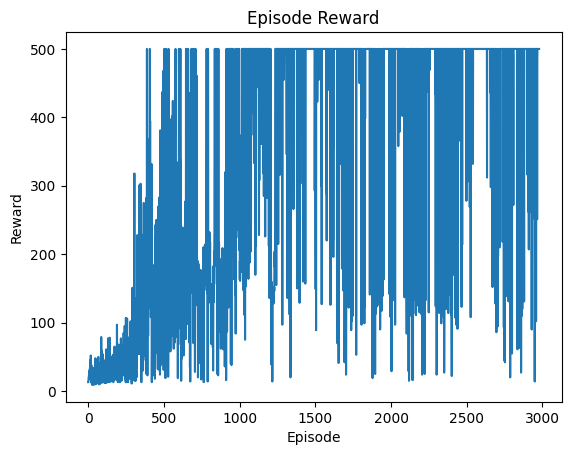

In [215]:
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Reward')
plt.show()


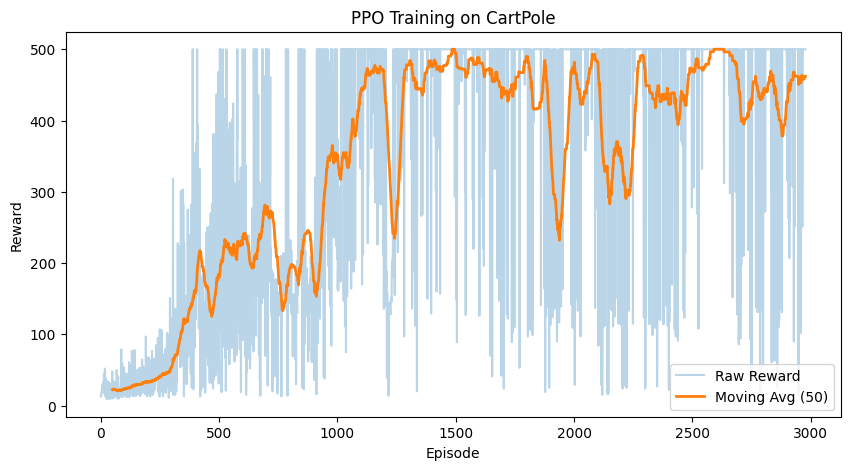

In [216]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.array(episode_rewards)

window = 50
moving_avg = np.convolve(
    rewards,
    np.ones(window)/window,
    mode='valid'
)

plt.figure(figsize=(10,5))
plt.plot(rewards, alpha=0.3, label="Raw Reward")
plt.plot(range(window-1, len(rewards)), moving_avg, linewidth=2, label="Moving Avg (50)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO Training on CartPole")
plt.legend()
plt.show()


In [217]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import os

video_folder = "./cartpole_videos"

env = gym.make("CartPole-v1", render_mode="rgb_array")

env = RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=lambda episode_id: True  # record every episode
)


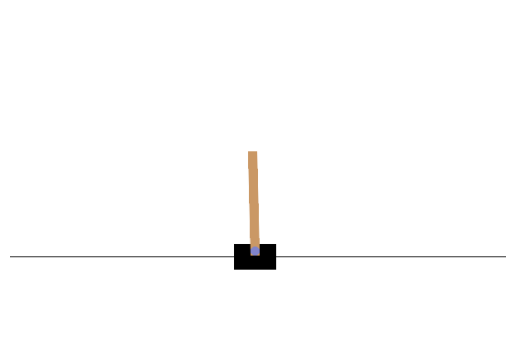

In [222]:
from matplotlib import animation
from IPython.display import HTML

env = gym.make("CartPole-v1", render_mode="rgb_array")

frames = []
obs, _ = env.reset()
done = False

while not done:
    frames.append(env.render())

    obs_np = obs_rms.normalize(obs)
    obs_t = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        action, _, _ = model.act(obs_t)

    obs, reward, terminated, truncated, _ = env.step(action.cpu().numpy()[0])
    done = terminated or truncated

env.close()

# Create animation
fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return [im]

anim = animation.FuncAnimation(fig, animate,
                                frames=len(frames),
                                interval=20)

HTML(anim.to_jshtml())
